#### 파이프라인?
```
데이터 전처리, 특성, 추출, 모델학습을 하나의 흐름으로 연결
```
#### 사용이유
```
코드 간결화 : 여러단계를 하나로 묶어 관리
재현성 보장 : 전체 프로세스를 일관되게 실행
데이터 누수 방지 : 교차 검증시 각 fold에서 독립적으로 전처리
하이퍼 파라메터 뉴팅 용이 : 전체 파이프라인에 대해서 그리드서치 사용
```
#### 파이프라인 구성요소
```
변환기
    데이터를 변환하는 객체
    fit() : 데이터에서 파라메터를 학습
    transform() : 학습 파라메터로 데이터를 변환
    StandardScaler, PCA, MinMaxScaler ...
추정기
    머신러닝 모델
    fit() : 데이터로 모델을 학습
    predict() : 예측 수행
    RandomForest, SVM ...
```
#### 데이터 : 위스콘시 유방암 데이터 대표적인 이진분류 데이터
```
클래스 2(양성, 악성)
특성 : 10개

```


In [21]:
# 파이프라인 구성
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression     #각 클래스에 대한 확률값을 출력 이후 이 확률값이 큰 클래스가 선택, 결국 분류모델
pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('pca', PCA(n_components=2)),
    ('classifier', LogisticRegression())
])

#### 파이프라인 실행과정
```
pipe.fit(x_train, y_train)
StandardScaler x_train에 fit --> 평균과 표준편차 계산
x_train을 표준화 x_scaled
PCA가 x_scaled fit --> 주성분 계산
x_scaled 변환 x_pca
LogisticRegression이 x_pca fit
```

#### 데이터 누수 방지
```
잘못된 예
전체 데이터를 먼저 스케일링
x_scaled = scaler.fit_transform(x)
x_train, x_test = train_test + split(x_scaled)
model.fit(x_train, y_train)
```
문제 --> 테스트 데이터 정보가 스케일에 사용
```
올바른 예
학습 데이터만으로 스케일링
x_train, x_test = train_test_split(x)
x_train_scaled = scaler.fit_transform(x_train)
x_test_scaled = scaler.transform(x_test)    # fit없이 transform만!!!
model.fit(x_train_scaled, y_train)

#### 파이프라인 사용(best)
```
pipe.fit(x_train, y_train)  # 학습 데이터만 fit
pipe.predict(x_test)    # 테스트 데이터는 transform만
```

#### 교차검증... k-겹
```
홀드아웃 : 데이터를 학습세트 테스트 세트 한번만 분할
전체데이터 100%
    학습 70 ~ 80%
    테스트 20 ~ 30%
장점 :
    빠르다
    대용량 데이터에 적합
단점 :
    데이터 분할에 따라서 성능이 크게 달라질 수 있음
    작은 데이터셋은 불안하다
    일부 데이터만 학습에 사용이 될 경우가 많다
언제 사용하는가?
    데이터가 충분히 많을 때 (수만개 이상)
    적더라도 빠르게 평가할 때
```

```
k-겹 교차검증(k-fold Cross-Validation)

```


#### k-fold
```
일반 k-fold
층화 Stratified k-fold
```

#### 학습곡선과 검증곡선
```
학습 데이터 크기에 따른 모델 성능을 시각화
```

#### 그리드 서치를 사용한 머신러닝 모델 세부 튜닝
```
하이퍼 파라메터
    파라메터 : 학습으로 찾음
        선형회귀 계수, 신경망의 가중치
        ...
    하이퍼 파라메터 : 사람이 설정
        학습률
        정규화
        트리의 깊이
        ...
그리드 서치 : 모든 가능한 조합으로 체계적으로 시도
param_grid = {
    'max_depth' : [3,5,],
    ...
}
랜덤 그리드 서치 : 모든 가능한 조합을 랜덤하게 
    장점 : 더 넓은 영역을 탐색 -> 파라메터의 조합의 경우의 수
    시간제약이 있을 때
언제 사용?
    그리드 서치 : 하이퍼 파라메터가 2~3개
    랜덤 그리드 서치 : 하이퍼 파라메터가 4개 이상
그리드 서치(각3개 값)
A : 3개의 고유값 
B : 3개의 고유값
랜덤 그리드 서치(9번 시도)
서로 다른 최대 9개의 값으로 시도
중요한 파라메터에 더 많은 시도
```

In [22]:
# 필요한 라이브러리
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import(
    train_test_split, cross_val_score, StratifiedKFold,
    learning_curve, validation_curve, GridSearchCV, RandomizedSearchCV,
    cross_validate
)

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline, make_pipeline
from scipy.stats import randint, uniform
import warnings
import pandas as pd
warnings.filterwarnings('ignore')

In [23]:
# section 1  : 위스콘신 유방망 데이터셋 로드 및 탐색
def section1_load_data():
    """
        데이터셋 구조 이해
        특성과 타겟의 관계 파악
        클래스 분포 확인
    """
    print("section 1 : 위스콘신 유방암 데이터셋")

    # 데이터 로드
    data = load_breast_cancer()
    X, y = data.data, data.target
    print("데이터셋 기본정보")
    print(f'샘플 수 : { X.shape[0] }')
    print(f'특성 수 : { X.shape[1] }')
    print(f'클래스 : {data.target_names}')
    # 클래스 분포
    unique, counts =  np.unique(y,return_counts=True)
    print("클래스분포")
    for label, count in zip(unique, counts):
        class_name = data.target_names[label]
        percentage = count / len(y) * 100
        print(f' {class_name} : {count}개 ({percentage:.1f}%)')
    # 특성 통계
    print("특성 통계 (처음 5개 특성)")
    df_lists = []
    for i in range(5):
        index_name = data.feature_names[i]
        stats = {
                'mean': X[:,i].mean(),
                    'std':X[:,i].std(),
                    'min':X[:,i].min(),
                    'max':X[:,i].max()
        }    
        df_lists.append(pd.DataFrame(stats,index = [index_name]))
    print(pd.concat(df_lists))
    return X, y, data

In [24]:
X,y,data = section_load_data()

NameError: name 'section_load_data' is not defined

In [ ]:
# session 2 파이프라인 기본 사용법

In [ ]:
def section2_basic_pipeline(X,y):
    """ 
    - Pipeline 객체생성
    - 표준화 + 모델 학습을 한번에 수행
    - 파이프라인의 장점을 이해
    """
    # 데이터 분할
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

    # 수동방식
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    lr = LogisticRegression(random_state=42, max_iter=1000)
    lr.fit(X_train_scaled, y_train)
    manual_score = lr.score(X_test_scaled, y_test)
    print(f'학습세트 크기 : {X_train.shape[0]}')
    print(f'테스트세트 크기 : {X_test.shape[0]}')
    print(f'테스트 정확도 : { manual_score:.4f}')    

    print('파이프라인', '*'*100)
    pipe = Pipeline([
        ('scaler', StandardScaler()),
        ('classifier', LogisticRegression(random_state=42, max_iter =1000))
    ])
    pipe.fit(X_train, y_train)
    pipeline_score = pipe.score(X_test, y_test)
    print(f'파이프라인 구조')
    for name, step in pipe.steps:
        print(f' {name} : {step.__class__.__name__} ')

    print(f"테스트 정확도 : {pipeline_score:.4f}")
    print(f'수동방식과 동일한 결과 : {np.isclose(manual_score, pipeline_score)}')

In [ ]:
section2_basic_pipeline(X,y)

학습세트 크기 : 398
테스트세트 크기 : 171
테스트 정확도 : 0.9883
파이프라인 ****************************************************************************************************
파이프라인 구조
 scaler : StandardScaler 
 classifier : LogisticRegression 
테스트 정확도 : 0.9883
수동방식과 동일한 결과 : True


In [ ]:
# 교차 검증 비교(홀드아웃 vs k-겹)
def section3_cross_validation(X, y):
    """
    - 홀드아웃의 한계
    - k-겹 교차검증의 장점
    - 층화 k-겹의 중요성
    """
    pipe = Pipeline([
        ('scaler',  StandardScaler() ),
        ('classifier', LogisticRegression(random_state=42, max_iter=1000) )
    ])
    # 여러번 반복해서 불안정성 확인
    holdout_scores = []
    for i in range(10):
        X_train,X_test,y_train,y_test = train_test_split(X, y, test_size=0.3, random_state=i)
        pipe.fit(X_train,y_train)
        holdout_score = pipe.score(X_test, y_test)
        holdout_scores.append(holdout_score) 
        # 처음 3개만 출력
        if i <3:
            print(f'  {i+1} : {holdout_score:.4f}')
    print('---')
    print(f'홀드아웃 평균 : {np.mean(holdout_scores):.4f}  표준편차 : {np.std(holdout_scores):.4f}')
    print(f'min : {np.min(holdout_scores)}   max : {np.max(holdout_scores)}')

    # 5-겹 교차 검증
    cv_scores = cross_val_score(pipe,X,y,cv=5,scoring='accuracy')
    print('각 Fold의 점수')
    for i, score in enumerate(cv_scores,1):
        print(f' fold {i} : {score:.4f}')
    print(f'교차검증 평균 : {np.mean(cv_scores):.4f}  표준편차 : {np.std(cv_scores):.4f}')

    print('-'*100)
    # 층화 k 겹
    skf = StratifiedKFold(n_splits=5,shuffle=True,random_state=42)
    stratified_scores = cross_val_score(pipe,X,y,cv=skf,scoring='accuracy')
    print('각 Fold의 점수')
    for i, score in enumerate(stratified_scores,1):
        print(f' fold {i} : {score:.4f}')
    print(f'층화 교차검증 평균 : {np.mean(stratified_scores):.4f}  표준편차 : {np.std(stratified_scores):.4f}')

    # 각 fold의 클래스 분포 확인
    for i, (train_index, test_index) in enumerate(skf.split(X,y),1):
        y_fold =  y[test_index]
        unique,counts =  np.unique(y_fold, return_counts =True)
        ratio = counts[1] / len(y_fold) * 100
        print(f' fold {i} : 악성 {ratio:.1f}%')

    
    print("결론")
    print(f' 홀드아웃 : 분할에 따라 성능차이가 큼 : {np.std(holdout_scores):.4f}')
    print(f' k-겹 : 더 안정적인 추정가능 : {np.std(cv_scores):.4f}')
    print(f' 층화 k-겹 : 클래스 비율유지로 더 신뢰성 있음')

In [ ]:
section3_cross_validation(X,y)

  1 : 0.9766
  2 : 0.9708
  3 : 0.9708
---
홀드아웃 평균 : 0.9766  표준편차 : 0.0074
min : 0.9649122807017544   max : 0.9883040935672515
각 Fold의 점수
 fold 1 : 0.9825
 fold 2 : 0.9825
 fold 3 : 0.9737
 fold 4 : 0.9737
 fold 5 : 0.9912
교차검증 평균 : 0.9807  표준편차 : 0.0065
----------------------------------------------------------------------------------------------------
각 Fold의 점수
 fold 1 : 0.9737
 fold 2 : 0.9474
 fold 3 : 0.9649
 fold 4 : 0.9912
 fold 5 : 0.9912
층화 교차검증 평균 : 0.9737  표준편차 : 0.0166
 fold 1 : 악성 62.3%
 fold 2 : 악성 62.3%
 fold 3 : 악성 63.2%
 fold 4 : 악성 63.2%
 fold 5 : 악성 62.8%
결론
 홀드아웃 : 분할에 따라 성능차이가 큼 : 0.0074
 k-겹 : 더 안정적인 추정가능 : 0.0065
 층화 k-겹 : 클래스 비율유지로 더 신뢰성 있음


In [ ]:
# 섹션 4 : 학습곡선으로 편향-분산 분석
def section4_learning_curves(X,y):
    """
    - 학습곡선
    - 과소적합 / 과대적합 판단
    - 데이터 추가 필요성 판단
    """
    print('다양한 모델의 학습곡선 비교')
    models = [
        ('underfit\n(simple model)', 
         Pipeline([('sacler',StandardScaler()),('clf',LogisticRegression(C=0.01,max_iter = 1000))]) ),  # C는 규제강도

        ('normal\n(basic model)', 
         Pipeline([('sacler',StandardScaler()),('clf',LogisticRegression(C=1.0,max_iter = 1000))]) ),

        ('small overfit \n(complex model)', 
         Pipeline([('sacler',StandardScaler()),('clf',SVC(kernel='rbf',gamma='auto'))]) ),

        ('overfit\n(strong complex model)', 
         Pipeline([('sacler',StandardScaler()),('clf',DecisionTreeClassifier())]) ),
    ]
    fig, axes = plt.subplots(2,2,figsize=(15,12))

    for idx, (title, model) in enumerate(models):
        ax = axes[idx // 2, idx % 2] # (0, 0) (0, 1) (1, 0) (1, 1)
        # 학습곡선 계산
        train_sizes,train_score,test_score =          learning_curve(
            model,X,y,cv=5,
            train_sizes=np.linspace(0.1,1.0,10),
            scoring='accuracy',
            n_jobs=-1
        )
        # 평균과 표준편차
        train_mean = train_score.mean(axis=1)
        train_std =  train_score.std(axis=1)
        test_mean = test_score.mean(axis=1)
        test_std = test_score.std(axis=1)

        # 그래프 그리기
        ax.plot(train_sizes,train_mean, label='train score', marker='o', color='blue')
        ax.fill_between(train_sizes, train_mean - train_std, train_mean+train_std, alpha=0.15, color='blue')

        ax.plot(train_sizes,test_mean, label='test score', marker='s', color='red')
        ax.fill_between(train_sizes, test_mean - test_std, test_mean+test_std, alpha=0.15, color='red')

        ax.set_xlabel('train sample counts', fontsize=10)
        ax.set_ylabel('accuracy', fontsize=10)
        ax.set_title(title, fontsize=12, fontweight='bold')
        ax.legend()
        ax.grid(True, alpha=0.3)
        ax.set_ylim([0.5,1.05])

        # 최종성능 출력
        final_train = train_mean[-1]
        final_test = test_mean[-1]
        gap = final_train - final_test

        print(f' 최종 학습점수 : {final_train}')
        print(f' 최종 검증점수 : {final_test}')
        print(f' 점수차이 : {gap}')

        if gap < 0.05 and final_test < 0.85:
            print(' 진단 : 과소적합(높은 편향)')
            print(' 해결책 : 더 복잡한 모델 사용')
        elif gap > 0.15:
            print(' 진단 : 과대적합(높은 분산)')
            print(' 해결책 : 더 많은 데이터 수집 또는 정규화 증가')
        else:
            print(' 진단 : 적절한 적합')

다양한 모델의 학습곡선 비교
 최종 학습점수 : 0.9556043956043956
 최종 검증점수 : 0.9490607048594939
 점수차이 : 0.006543690744901687
 진단 : 적절한 적합
 최종 학습점수 : 0.9894505494505494
 최종 검증점수 : 0.9806862288464524
 점수차이 : 0.008764320604097042
 진단 : 적절한 적합
 최종 학습점수 : 0.9872527472527473
 최종 검증점수 : 0.9736376339077782
 점수차이 : 0.01361511334496901
 진단 : 적절한 적합
 최종 학습점수 : 1.0
 최종 검증점수 : 0.9173575531749728
 점수차이 : 0.0826424468250272
 진단 : 적절한 적합


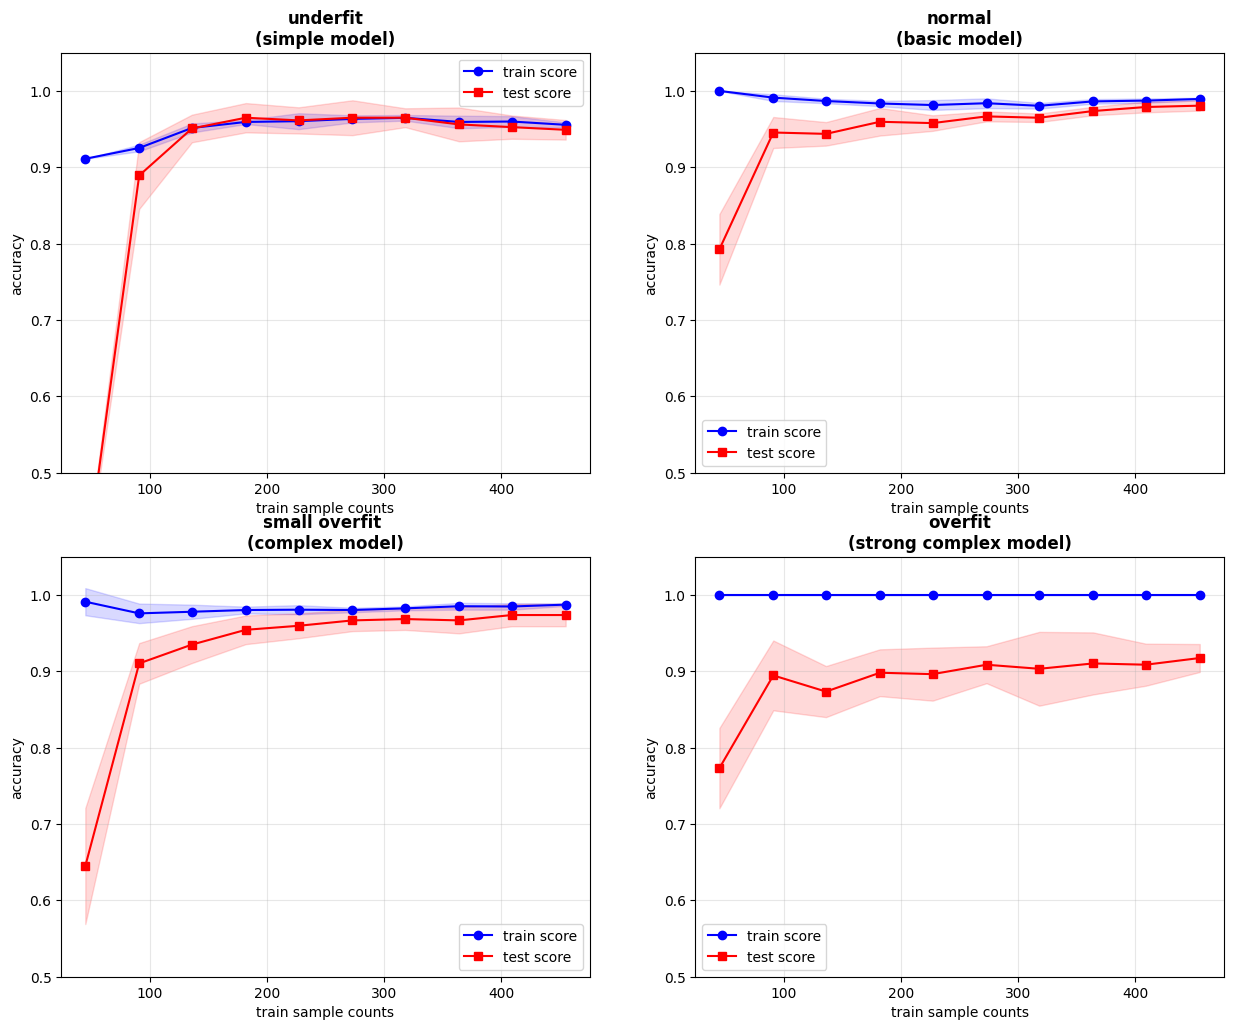

In [ ]:
section4_learning_curves(X,y)

In [ ]:
# 검증곡선으로 하이퍼 파라메터 분석
def section5_validation_curve(X, y):
    """
    - 검증곡선
    - 최적 화이퍼파라메터 범위 확인
    - 과대/과소 적합 구간 확인
    """
    fig, ax = plt.subplots(1,2, figsize=(15,5))
    # Logistic Regression C 파라메터
    print(f'Logistic Regression 정규화 파라메터 C')
    print(f' ( C 가 적을수록 강한 정규화 )')

    pipe = Pipeline([
        ('scaler', StandardScaler()),
        ('clf', LogisticRegression(max_iter=1000))
    ])
    param_range = np.logspace(-4,4,9)  # 0.0001 ~ 10000
    train_scores, test_scores =  validation_curve(
        pipe,X,y,
        param_name='clf__C',
        param_range= param_range,
        cv=5,
        scoring='accuracy'  ,
        n_jobs = -1
    )
    # 평균과 표준편차
    train_mean = train_scores.mean(axis=1)
    train_std =  train_scores.std(axis=1)
    test_mean = test_scores.mean(axis=1)
    test_std = test_scores.std(axis=1)

    # 그래프 그리기  semilogx x축을 로그 스케일로 설정해서 선 을 그리는 함수  작은값부터 큰 값까지 폭 넒게 분포된 값을 시각화
    ax[0].semilogx(param_range,train_mean, label='train score', marker='o', color='blue')
    ax[0].fill_between(param_range, train_mean - train_std, train_mean+train_std, alpha=0.15, color='blue')

    ax[0].semilogx(param_range,test_mean, label='test score', marker='s', color='red')
    ax[0].fill_between(param_range, test_mean - test_std, test_mean+test_std, alpha=0.15, color='red')

    ax[0].set_xlabel('Parameter C', fontsize=10)
    ax[0].set_ylabel('accuracy', fontsize=10)
    ax[0].set_title("logistic regression C ", fontsize=12, fontweight='bold')
    ax[0].legend()
    ax[0].grid(True, alpha=0.3)  

    # 최적의 값
    best_idx = np.argmax(test_mean)  
    best_c = param_range[best_idx]
    best_score = test_mean[best_idx]

    print(f'최적의 C : {best_c:.4f}')
    print(f'최고 검증 점수는 : {best_score:.4f}')

    # Decision Tree max_depth 파라메터

    pipe = Pipeline([
        ('scaler', StandardScaler()),
        ('clf', DecisionTreeClassifier())
    ])
    param_range = range(1,21)
    train_scores, test_scores =  validation_curve(
        pipe,X,y,
        param_name='clf__max_depth',
        param_range= param_range,
        cv=5,
        scoring='accuracy'  ,
        n_jobs = -1
    )
    # 평균과 표준편차
    train_mean = train_scores.mean(axis=1)
    train_std =  train_scores.std(axis=1)
    test_mean = test_scores.mean(axis=1)
    test_std = test_scores.std(axis=1)

    # 그래프 그리기  semilogx x축을 로그 스케일로 설정해서 선 을 그리는 함수  작은값부터 큰 값까지 폭 넒게 분포된 값을 시각화
    ax[1].semilogx(param_range,train_mean, label='train score', marker='o', color='blue')
    ax[1].fill_between(param_range, train_mean - train_std, train_mean+train_std, alpha=0.15, color='blue')

    ax[1].semilogx(param_range,test_mean, label='test score', marker='s', color='red')
    ax[1].fill_between(param_range, test_mean - test_std, test_mean+test_std, alpha=0.15, color='red')

    ax[1].set_xlabel('Parameter max_depth', fontsize=10)
    ax[1].set_ylabel('accuracy', fontsize=10)
    ax[1].set_title("logistic regression max_depth ", fontsize=12, fontweight='bold')
    ax[1].legend()
    ax[1].grid(True, alpha=0.3)  

    # 최적의 값
    best_idx = np.argmax(test_mean)  
    best_c = param_range[best_idx]
    best_score = test_mean[best_idx]

    print(f'최적의 max_depth : {best_c:.4f}')
    print(f'최고 검증 점수는 : {best_score:.4f}')

section5_validation_curve(X,y)